In [11]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import completions_module as cmodule

Load data.

In [12]:
# ucar list
all_files = glob.glob("../data/completions_*.csv")
all_files = sorted(all_files)
df_ucar = cmodule.open_and_concat(all_files)

# hsi list
all_files = glob.glob("../data/hsi_completions_*.csv")
all_files = sorted(all_files)
df_hsis = cmodule.open_and_concat(all_files)

# ehi list
all_files = glob.glob("../data/emerginghsi_completions_*.csv")
all_files = sorted(all_files)
df_ehis = cmodule.open_and_concat(all_files)

Concatenate the data from UCAR, HSI, EHI lists.

In [13]:
all_unis = pd.concat([df_ucar, df_hsis, df_ehis])

## Bar plot figure

In [14]:
df = cmodule.ms_degrees(all_unis)
df = cmodule.earth_and_atmos_sciences(df)

df['hsi'] = np.zeros(len(df))
df['ehi'] = np.zeros(len(df))

df = df.groupby('institution name').sum()[['Grand total',
                                           'Hispanic or Latino total',
                                           'hsi','ehi']].sort_values(
    'Hispanic or Latino total',ascending=False).head(10)

df['ehi'].loc['Stanford University']=1.0
df['ehi'].loc['Texas A & M University-College Station']=1.0
df['hsi'].loc['University of Houston']=1.0
df['hsi'].loc['The University of Texas at El Paso']=1.0
df['hsi'].loc['University of Puerto Rico-Mayaguez']=1.0
df['ehi'].loc['The University of Texas at Austin']=1.0
df['hsi'].loc['Florida International University']=1.0
df['hsi'].loc['University of Arizona']=1.0
df['hsi'].loc['CUNY Graduate School and University Center']=1.0
df['ehi'].loc['The University of Texas at Austin']=1.0
df['ehi'].loc['Florida State University']=1.0
df['hsi'].loc['California State University-Fresno']=1.0
df['hsi'].loc['The University of Texas Permian Basin']=1.0
df['hsi'].loc['California State University-Los Angeles']=1.0
df['ehi'].loc['University of California-San Diego']=1.0
df['hsi'].loc['San Diego State University']=1.0

ms_eas_num = df['Hispanic or Latino total'].values
ms_eas_uni = df.index
ms_eas_hsi = df['hsi'].values
ms_eas_ehi = df['ehi'].values

c_1 = []
colors = ['darkgrey','salmon','blue']

for num, i in enumerate(range(10)):
    
    if ms_eas_hsi[num] > 0:
        c_1.append(colors[1])
        
    elif ms_eas_ehi[num] > 0:
        c_1.append(colors[2])
        
    else:
        c_1.append(colors[0])

In [15]:
df = cmodule.ms_degrees(all_unis)
df = cmodule.atmospheric_sciences(df)

df['hsi'] = np.zeros(len(df))
df['ehi'] = np.zeros(len(df))

df = df.groupby('institution name').sum()[['Grand total',
                                           'Hispanic or Latino total',
                                           'hsi','ehi']].sort_values(
    'Hispanic or Latino total',ascending=False).head(10)

df['ehi'].loc['Texas A & M University-College Station']=1.0
df['hsi'].loc['The University of Texas at El Paso']=1.0
df['ehi'].loc['University of California-Los Angeles']=1.0
df['ehi'].loc['The University of Texas at Austin']=1.0
df['hsi'].loc['San Jose State University']=1.0
df['hsi'].loc['University of Arizona']=1.0
df['ehi'].loc['University of Nevada-Reno']=1.0
df['ehi'].loc['Florida State University']=1.0
df['ehi'].loc['SUNY at Albany']=1.0

ms_atm_num = df['Hispanic or Latino total'].values
ms_atm_uni = df.index
ms_atm_hsi = df['hsi'].values
ms_atm_ehi = df['ehi'].values

c_2 = []
colors = ['darkgrey','salmon','blue']

for num, i in enumerate(range(10)):
    
    if ms_atm_hsi[num] > 0:
        c_2.append(colors[1])
        
    elif ms_atm_ehi[num] > 0:
        c_2.append(colors[2])
        
    else:
        c_2.append(colors[0])

In [16]:
df = cmodule.phd_degrees(all_unis)
df = cmodule.earth_and_atmos_sciences(df)

df['hsi'] = np.zeros(len(df))
df['ehi'] = np.zeros(len(df))

df = df.groupby('institution name').sum()[['Grand total',
                                           'Hispanic or Latino total',
                                           'hsi','ehi']].sort_values(
    'Hispanic or Latino total',ascending=False).head(10)

df['ehi'].loc['University of South Florida-Main Campus']=1.0
df['hsi'].loc['The University of Texas at El Paso']=1.0
df['ehi'].loc['University of California-Los Angeles']=1.0
df['ehi'].loc['The University of Texas at Austin']=1.0
df['ehi'].loc['Stanford University']=1.0
df['hsi'].loc['University of Houston']=1.0
df['ehi'].loc['University of California-San Diego']=1.0
df['hsi'].loc['University of Arizona']=1.0
df['ehi'].loc['University of Nevada-Reno']=1.0
df['ehi'].loc['Florida State University']=1.0
df['ehi'].loc['SUNY at Albany']=1.0
df['hsi'].loc['CUNY Graduate School and University Center']=1.0
df['ehi'].loc['University of Southern California']=1.0
df['hsi'].loc['University of California-Santa Cruz']=1.0
df['ehi'].loc['University of Miami']=1.0
df['ehi'].loc['Massachusetts Institute of Technology']=1.0

dr_eas_num = df['Hispanic or Latino total'].values
dr_eas_uni = df.index
dr_eas_hsi = df['hsi'].values
dr_eas_ehi = df['ehi'].values

c_3 = []
colors = ['darkgrey','salmon','blue']

for num, i in enumerate(range(10)):
    
    if dr_eas_hsi[num] > 0:
        c_3.append(colors[1])
        
    elif dr_eas_ehi[num] > 0:
        c_3.append(colors[2])
        
    else:
        c_3.append(colors[0])

In [17]:
df = cmodule.phd_degrees(all_unis)
df = cmodule.atmospheric_sciences(df)

df['hsi'] = np.zeros(len(df))
df['ehi'] = np.zeros(len(df))

df = df.groupby('institution name').sum()[['Grand total',
                                           'Hispanic or Latino total',
                                           'hsi','ehi']].sort_values(
    'Hispanic or Latino total',ascending=False).head(10)

df['hsi'].loc['Howard University']=1.0
df['ehi'].loc['SUNY at Albany']=1.0
df['ehi'].loc['Florida State University']=1.0
df['ehi'].loc['University of California-Los Angeles']=1.0
df['ehi'].loc['Texas A & M University-College Station']=1.0
df['ehi'].loc['Massachusetts Institute of Technology']=1.0
df['ehi'].loc['University of Nevada-Reno']=1.0
df['ehi'].loc['University of California-Davis']=1.0

dr_atm_num = df['Hispanic or Latino total'].values
dr_atm_uni = df.index
dr_atm_hsi = df['hsi'].values
dr_atm_ehi = df['ehi'].values

c_4 = []
colors = ['darkgrey','salmon','blue']

for num, i in enumerate(range(10)):
    
    if dr_atm_hsi[num] > 0:
        c_4.append(colors[1])
        
    elif dr_atm_ehi[num] > 0:
        c_4.append(colors[2])
        
    else:
        c_4.append(colors[0])

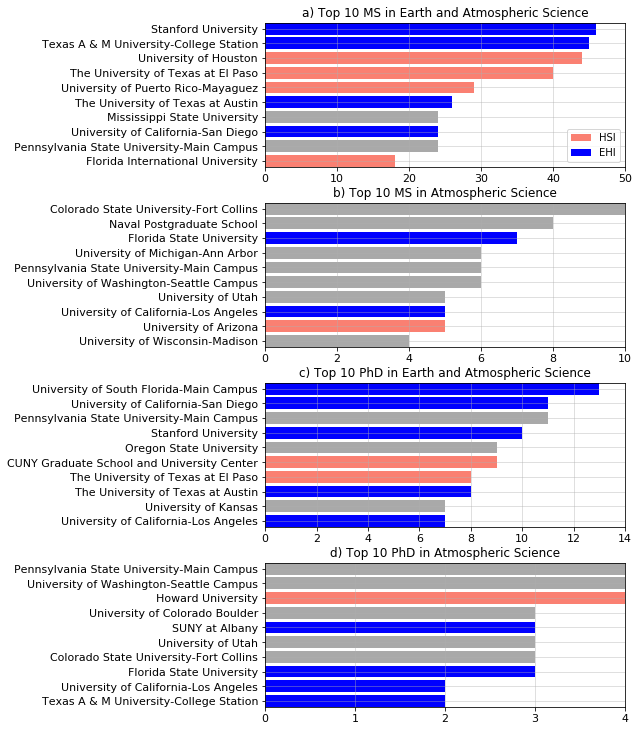

In [18]:
#-----------------------%

fig = plt.figure(figsize=(5.,10.))

#-----------------------%

ax1 = fig.add_axes([0.0, 0.75, 1.0, 0.2])
ax1.set_title('a) Top 10 MS in Earth and Atmospheric Science',
              fontsize=12)

br = ax1.barh(ms_eas_uni, ms_eas_num, color=c_1)
ax1.grid('--',alpha=0.5)
ax1.margins(x=0,y=0)
ax1.set_xticks([0,10,20,30,40,50])
ax1.set_xticklabels([0,10,20,30,40,50],fontsize=11)
ax1.set_yticks(ms_eas_uni)
ax1.set_yticklabels(ms_eas_uni,fontsize=11)
plt.gca().invert_yaxis()

ax1.legend([br[2],br[0]],['HSI','EHI'])

#-----------------------%

ax2 = fig.add_axes([0.0, 0.5, 1.0, 0.2])
ax2.set_title('b) Top 10 MS in Atmospheric Science',
              fontsize=12)

ax2.barh(ms_atm_uni, ms_atm_num, color=c_2)
ax2.grid('--',alpha=0.5)
ax2.margins(x=0,y=0)
ax2.set_xticks([0,2,4,6,8,10])
ax2.set_xticklabels([0,2,4,6,8,10],fontsize=11)
ax2.set_yticks(ms_atm_uni)
ax2.set_yticklabels(ms_atm_uni,fontsize=11)
plt.gca().invert_yaxis()

#-----------------------%

ax3 = fig.add_axes([0.0, 0.25, 1.0, 0.2])
ax3.set_title('c) Top 10 PhD in Earth and Atmospheric Science',
              fontsize=12)

ax3.barh(dr_eas_uni, dr_eas_num, color=c_3)
ax3.grid('--',alpha=0.5)
ax3.margins(x=0,y=0)
ax3.set_xticks([0,2,4,6,8,10,12,14])
ax3.set_xticklabels([0,2,4,6,8,10,12,14],fontsize=11)
ax3.set_yticks(dr_eas_uni)
ax3.set_yticklabels(dr_eas_uni,fontsize=11)
plt.gca().invert_yaxis()

#-----------------------%

ax4 = fig.add_axes([0.0, 0.0, 1.0, 0.2])
ax4.set_title('d) Top 10 PhD in Atmospheric Science',
              fontsize=12)

ax4.barh(dr_atm_uni, dr_atm_num, color=c_4)
ax4.grid('--',alpha=0.5)
ax4.margins(x=0,y=0)
ax4.set_xticks([0,1,2,3,4])
ax4.set_xticklabels([0,1,2,3,4],fontsize=11)
ax4.set_yticks(dr_atm_uni)
ax4.set_yticklabels(dr_atm_uni,fontsize=11)
plt.gca().invert_yaxis()

#-----------------------%

plt.savefig(f"../figures/fig1.png", bbox_inches='tight', dpi=500)
plt.show()

#-----------------------%